# TensorFlow Tutorial on MNIST

Based on tensorflow 1.2 (but it will probably work well on 1.1)

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import collections

In [2]:
tf.__version__

'1.2.1'

In [3]:
tf.set_random_seed(0) # does not ensure perfect reproducibility

In [4]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Train function

In [4]:
def train(epoch_n=20, batch_size=100, n_iter=None, use_training_ph=False):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    N = mnist.train.num_examples
    if n_iter is None:
        n_iter = N // batch_size
    # the last 5 accuracies will be used for the evaluation of a model
    dq = collections.deque(maxlen=5)
        
    for epoch in range(epoch_n):
        avg_loss = 0.
        avg_acc = 0.
        for _ in range(n_iter):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            feed_dict = {X: batch_x, y: batch_y}
            # In some algorithms, training phase is a little difference with test phase
            # so training flag is required.
            if use_training_ph:
                feed_dict[training] = True
            _, cur_acc, cur_loss = sess.run([train_op, accuracy, loss], feed_dict=feed_dict)
            avg_acc += cur_acc
            avg_loss += cur_loss

        avg_acc /= n_iter
        avg_loss /= n_iter

        # test acc/loss does not depend on batch size
        # so we can use the large batch size.
        test_acc = 0.
        test_loss = 0.
        for _ in range(mnist.test.num_examples // 1000):
            batch_x, batch_y = mnist.test.next_batch(1000)
            feed_dict = {X: batch_x, y: batch_y}
            if use_training_ph:
                feed_dict[training] = False
            cur_acc, cur_loss = sess.run([accuracy, loss], feed_dict=feed_dict)
            test_acc += cur_acc
            test_loss += cur_loss
        test_acc /= (mnist.test.num_examples // 1000)
        test_loss /= (mnist.test.num_examples // 1000)
        
        print("[{:2}/{}] (train) acc: {:.2%}, loss: {:.3f} | (test) acc: {:.2%}, loss: {:.3f}".
              format(epoch+1, epoch_n, avg_acc, avg_loss, test_acc, test_loss))
        dq.append(test_acc)
    
    score = np.average(dq)
    print("average of last 5 test acc: {:.2%}".format(score))

# Multi-Layer Perceptron (MLP)

## 1-hidden layer percentron

In [5]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

w1 = tf.get_variable('w1', [784, 256], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1))
b1 = tf.get_variable('b1', [256], initializer=tf.zeros_initializer)
w2 = tf.get_variable('w2', [256, 10], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1))
b2 = tf.get_variable('b2', [10], initializer=tf.zeros_initializer)

h1 = tf.nn.sigmoid(tf.matmul(X, w1) + b1)
logits = tf.matmul(h1, w2) + b2
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [6]:
train()

[ 1/20] (train) acc: 81.04%, loss: 0.775 | (test) acc: 88.77%, loss: 0.433
[ 2/20] (train) acc: 88.86%, loss: 0.400 | (test) acc: 90.35%, loss: 0.347
[ 3/20] (train) acc: 90.15%, loss: 0.346 | (test) acc: 91.12%, loss: 0.314
[ 4/20] (train) acc: 90.77%, loss: 0.319 | (test) acc: 91.49%, loss: 0.295
[ 5/20] (train) acc: 91.33%, loss: 0.301 | (test) acc: 91.78%, loss: 0.281
[ 6/20] (train) acc: 91.70%, loss: 0.288 | (test) acc: 92.12%, loss: 0.271
[ 7/20] (train) acc: 92.05%, loss: 0.276 | (test) acc: 92.25%, loss: 0.263
[ 8/20] (train) acc: 92.36%, loss: 0.265 | (test) acc: 92.64%, loss: 0.253
[ 9/20] (train) acc: 92.67%, loss: 0.255 | (test) acc: 92.83%, loss: 0.245
[10/20] (train) acc: 92.99%, loss: 0.245 | (test) acc: 93.23%, loss: 0.240
[11/20] (train) acc: 93.25%, loss: 0.236 | (test) acc: 93.28%, loss: 0.228
[12/20] (train) acc: 93.49%, loss: 0.228 | (test) acc: 93.35%, loss: 0.225
[13/20] (train) acc: 93.75%, loss: 0.220 | (test) acc: 93.81%, loss: 0.216
[14/20] (train) acc: 93.9

## tf.contrib.slim

https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim

TF-Slim is a lightweight library for defining, training and evaluating complex model in TensorFlow. Components of tf-slim can be freely mixed with native tensorflow.

In [7]:
# same as `import tensorflow.contrib.slim as slim`
slim = tf.contrib.slim 

In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

h1 = slim.fully_connected(X, 256, activation_fn=tf.nn.sigmoid, 
                          weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1), 
                          biases_initializer=tf.zeros_initializer())
logits = slim.fully_connected(h1, 10, activation_fn=None, 
                              weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1), 
                              biases_initializer=tf.zeros_initializer())
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [9]:
train()

[ 1/20] (train) acc: 80.48%, loss: 0.781 | (test) acc: 88.69%, loss: 0.426
[ 2/20] (train) acc: 88.90%, loss: 0.397 | (test) acc: 90.14%, loss: 0.346
[ 3/20] (train) acc: 90.16%, loss: 0.344 | (test) acc: 91.11%, loss: 0.312
[ 4/20] (train) acc: 90.81%, loss: 0.317 | (test) acc: 91.66%, loss: 0.293
[ 5/20] (train) acc: 91.39%, loss: 0.300 | (test) acc: 91.85%, loss: 0.279
[ 6/20] (train) acc: 91.79%, loss: 0.286 | (test) acc: 92.25%, loss: 0.267
[ 7/20] (train) acc: 92.08%, loss: 0.274 | (test) acc: 92.62%, loss: 0.260
[ 8/20] (train) acc: 92.43%, loss: 0.264 | (test) acc: 92.75%, loss: 0.254
[ 9/20] (train) acc: 92.76%, loss: 0.254 | (test) acc: 93.09%, loss: 0.245
[10/20] (train) acc: 92.97%, loss: 0.245 | (test) acc: 93.12%, loss: 0.234
[11/20] (train) acc: 93.23%, loss: 0.236 | (test) acc: 93.48%, loss: 0.228
[12/20] (train) acc: 93.48%, loss: 0.228 | (test) acc: 93.57%, loss: 0.223
[13/20] (train) acc: 93.74%, loss: 0.220 | (test) acc: 93.89%, loss: 0.214
[14/20] (train) acc: 93.9

## Better MLP - ReLU, xavier_init, adam

* Nair, Vinod, and Geoffrey E. Hinton. "Rectified linear units improve restricted boltzmann machines." Proceedings of the 27th international conference on machine learning (ICML-10). 2010.
* Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics. 2010.
* Kingma, Diederik, and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).

In [10]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

h1 = slim.fully_connected(X, 256, activation_fn=tf.nn.relu, weights_initializer=slim.xavier_initializer())
logits = slim.fully_connected(h1, 10, activation_fn=None, weights_initializer=slim.xavier_initializer())
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [11]:
train()

[ 1/20] (train) acc: 91.44%, loss: 0.306 | (test) acc: 95.38%, loss: 0.156
[ 2/20] (train) acc: 96.25%, loss: 0.130 | (test) acc: 96.38%, loss: 0.120
[ 3/20] (train) acc: 97.44%, loss: 0.088 | (test) acc: 97.30%, loss: 0.090
[ 4/20] (train) acc: 98.11%, loss: 0.064 | (test) acc: 97.43%, loss: 0.080
[ 5/20] (train) acc: 98.59%, loss: 0.049 | (test) acc: 97.56%, loss: 0.074
[ 6/20] (train) acc: 98.94%, loss: 0.038 | (test) acc: 97.78%, loss: 0.069
[ 7/20] (train) acc: 99.19%, loss: 0.029 | (test) acc: 98.06%, loss: 0.064
[ 8/20] (train) acc: 99.38%, loss: 0.023 | (test) acc: 97.88%, loss: 0.067
[ 9/20] (train) acc: 99.48%, loss: 0.019 | (test) acc: 97.87%, loss: 0.064
[10/20] (train) acc: 99.61%, loss: 0.015 | (test) acc: 97.72%, loss: 0.074
[11/20] (train) acc: 99.72%, loss: 0.012 | (test) acc: 98.14%, loss: 0.064
[12/20] (train) acc: 99.85%, loss: 0.008 | (test) acc: 97.99%, loss: 0.071
[13/20] (train) acc: 99.78%, loss: 0.009 | (test) acc: 98.05%, loss: 0.071
[14/20] (train) acc: 99.8

## Going Deeper

In [12]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

# slim.fully_connected use relu and xavier_init as default
h1 = slim.fully_connected(X, 256)
h2 = slim.fully_connected(h1, 128)
logits = slim.fully_connected(h2, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [13]:
train()

[ 1/20] (train) acc: 92.23%, loss: 0.272 | (test) acc: 96.31%, loss: 0.122
[ 2/20] (train) acc: 97.11%, loss: 0.099 | (test) acc: 97.19%, loss: 0.091
[ 3/20] (train) acc: 97.96%, loss: 0.066 | (test) acc: 97.74%, loss: 0.076
[ 4/20] (train) acc: 98.58%, loss: 0.046 | (test) acc: 97.98%, loss: 0.068
[ 5/20] (train) acc: 98.86%, loss: 0.035 | (test) acc: 97.65%, loss: 0.081
[ 6/20] (train) acc: 99.18%, loss: 0.026 | (test) acc: 97.54%, loss: 0.082
[ 7/20] (train) acc: 99.31%, loss: 0.022 | (test) acc: 97.87%, loss: 0.079
[ 8/20] (train) acc: 99.49%, loss: 0.017 | (test) acc: 97.48%, loss: 0.093
[ 9/20] (train) acc: 99.52%, loss: 0.015 | (test) acc: 98.01%, loss: 0.076
[10/20] (train) acc: 99.51%, loss: 0.014 | (test) acc: 97.78%, loss: 0.082
[11/20] (train) acc: 99.69%, loss: 0.010 | (test) acc: 97.71%, loss: 0.095
[12/20] (train) acc: 99.67%, loss: 0.010 | (test) acc: 97.84%, loss: 0.089
[13/20] (train) acc: 99.50%, loss: 0.014 | (test) acc: 97.86%, loss: 0.094
[14/20] (train) acc: 99.6

* No better acc ...

# Convolutional Neural Networks (CNN)

* [`conv`, `maxpool`] * 2 + `fc`

In [14]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

x_img = tf.reshape(X, [-1, 28, 28, 1])

# slim.conv2d uses relu and xavier init as default
h1 = slim.conv2d(x_img, 32, kernel_size=[3,3]) 
p1 = slim.max_pool2d(h1, kernel_size=[2,2])
# checking dimensions for each layer is very helpful
assert p1.shape[1:] == [14, 14, 32]

h2 = slim.conv2d(p1, 64, kernel_size=[3,3])
p2 = slim.max_pool2d(h2, kernel_size=[2,2])
assert p2.shape[1:] == [7, 7, 64]

flat = slim.flatten(p2)
logits = slim.fully_connected(flat, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [15]:
train()

[ 1/20] (train) acc: 92.74%, loss: 0.244 | (test) acc: 97.86%, loss: 0.060
[ 2/20] (train) acc: 97.98%, loss: 0.066 | (test) acc: 98.42%, loss: 0.048
[ 3/20] (train) acc: 98.48%, loss: 0.050 | (test) acc: 98.65%, loss: 0.042
[ 4/20] (train) acc: 98.76%, loss: 0.040 | (test) acc: 98.76%, loss: 0.038
[ 5/20] (train) acc: 98.95%, loss: 0.034 | (test) acc: 98.76%, loss: 0.038
[ 6/20] (train) acc: 99.09%, loss: 0.028 | (test) acc: 98.69%, loss: 0.037
[ 7/20] (train) acc: 99.26%, loss: 0.024 | (test) acc: 98.74%, loss: 0.035
[ 8/20] (train) acc: 99.34%, loss: 0.021 | (test) acc: 98.85%, loss: 0.034
[ 9/20] (train) acc: 99.42%, loss: 0.018 | (test) acc: 98.71%, loss: 0.037
[10/20] (train) acc: 99.49%, loss: 0.016 | (test) acc: 99.01%, loss: 0.036
[11/20] (train) acc: 99.63%, loss: 0.012 | (test) acc: 98.95%, loss: 0.034
[12/20] (train) acc: 99.64%, loss: 0.011 | (test) acc: 98.93%, loss: 0.035
[13/20] (train) acc: 99.65%, loss: 0.011 | (test) acc: 98.99%, loss: 0.036
[14/20] (train) acc: 99.7

## Deeper ... 

* [`conv`, `maxpool`] * 3 + `fc`

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

x_img = tf.reshape(X, [-1, 28, 28, 1])

h1 = slim.conv2d(x_img, 32, kernel_size=[3,3]) 
p1 = slim.max_pool2d(h1, kernel_size=[2,2])
assert p1.shape[1:] == [14, 14, 32]

h2 = slim.conv2d(p1, 64, kernel_size=[3,3])
p2 = slim.max_pool2d(h2, kernel_size=[2,2])
assert p2.shape[1:] == [7, 7, 64]

h3 = slim.conv2d(p2, 128, kernel_size=[3,3])
p3 = slim.max_pool2d(h3, kernel_size=[2,2], padding='same')
assert p3.shape[1:] == [4, 4, 128]

flat = slim.flatten(p3)
logits = slim.fully_connected(flat, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [17]:
train(epoch_n=100)

[ 1/100] (train) acc: 93.49%, loss: 0.211 | (test) acc: 98.20%, loss: 0.053
[ 2/100] (train) acc: 98.27%, loss: 0.054 | (test) acc: 98.85%, loss: 0.038
[ 3/100] (train) acc: 98.90%, loss: 0.035 | (test) acc: 99.09%, loss: 0.029
[ 4/100] (train) acc: 99.16%, loss: 0.027 | (test) acc: 98.95%, loss: 0.033
[ 5/100] (train) acc: 99.27%, loss: 0.022 | (test) acc: 99.05%, loss: 0.028
[ 6/100] (train) acc: 99.37%, loss: 0.019 | (test) acc: 99.17%, loss: 0.024
[ 7/100] (train) acc: 99.56%, loss: 0.014 | (test) acc: 98.98%, loss: 0.034
[ 8/100] (train) acc: 99.62%, loss: 0.013 | (test) acc: 99.31%, loss: 0.021
[ 9/100] (train) acc: 99.62%, loss: 0.011 | (test) acc: 99.01%, loss: 0.032
[10/100] (train) acc: 99.65%, loss: 0.010 | (test) acc: 99.05%, loss: 0.032
[11/100] (train) acc: 99.74%, loss: 0.008 | (test) acc: 99.10%, loss: 0.030
[12/100] (train) acc: 99.75%, loss: 0.007 | (test) acc: 99.23%, loss: 0.026
[13/100] (train) acc: 99.81%, loss: 0.006 | (test) acc: 99.23%, loss: 0.027
[14/100] (tr

## More Deeper ... (VGGNet-like)

Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).

* [`conv`, `conv`, `maxpool`] * 3 + `fc`

In [18]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

x_img = tf.reshape(X, [-1, 28, 28, 1])

h1 = slim.conv2d(x_img, 32, kernel_size=[3,3]) # default relu, xavier
h1 = slim.conv2d(h1, 32, kernel_size=[3,3])
p1 = slim.max_pool2d(h1, kernel_size=[2,2])
assert p1.shape[1:] == [14, 14, 32]

h2 = slim.conv2d(p1, 64, kernel_size=[3,3])
h2 = slim.conv2d(h2, 64, kernel_size=[3,3])
p2 = slim.max_pool2d(h2, kernel_size=[2,2])
assert p2.shape[1:] == [7, 7, 64]

h3 = slim.conv2d(p2, 128, kernel_size=[3,3])
h3 = slim.conv2d(h3, 128, kernel_size=[3,3])
p3 = slim.max_pool2d(h3, kernel_size=[2,2], padding='same')
assert p3.shape[1:] == [4, 4, 128]

flat = slim.flatten(p3)
logits = slim.fully_connected(flat, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [19]:
train(epoch_n=100)

[ 1/100] (train) acc: 94.74%, loss: 0.161 | (test) acc: 98.74%, loss: 0.040
[ 2/100] (train) acc: 98.67%, loss: 0.042 | (test) acc: 98.99%, loss: 0.028
[ 3/100] (train) acc: 99.10%, loss: 0.029 | (test) acc: 98.94%, loss: 0.034
[ 4/100] (train) acc: 99.28%, loss: 0.022 | (test) acc: 99.17%, loss: 0.027
[ 5/100] (train) acc: 99.44%, loss: 0.017 | (test) acc: 98.95%, loss: 0.035
[ 6/100] (train) acc: 99.47%, loss: 0.016 | (test) acc: 99.18%, loss: 0.027
[ 7/100] (train) acc: 99.63%, loss: 0.012 | (test) acc: 99.11%, loss: 0.031
[ 8/100] (train) acc: 99.58%, loss: 0.012 | (test) acc: 99.22%, loss: 0.026
[ 9/100] (train) acc: 99.70%, loss: 0.010 | (test) acc: 99.27%, loss: 0.029
[10/100] (train) acc: 99.69%, loss: 0.010 | (test) acc: 99.25%, loss: 0.025
[11/100] (train) acc: 99.76%, loss: 0.007 | (test) acc: 99.31%, loss: 0.025
[12/100] (train) acc: 99.75%, loss: 0.007 | (test) acc: 99.35%, loss: 0.025
[13/100] (train) acc: 99.79%, loss: 0.007 | (test) acc: 99.30%, loss: 0.034
[14/100] (tr

## Dropout

Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." Journal of Machine Learning Research 15.1 (2014): 1929-1958.

* [`conv`, `conv`, `maxpool`, `dropout`] * 3 + `fc`

Effects:
* ensemble
* regularization
    * avoid co-adaptation of weights

In [20]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder(tf.bool)

x_img = tf.reshape(X, [-1, 28, 28, 1])

h1 = slim.conv2d(x_img, 32, kernel_size=[3,3]) # default relu, xavier
h1 = slim.conv2d(h1, 32, kernel_size=[3,3])
p1 = slim.max_pool2d(h1, kernel_size=[2,2])
d1 = slim.dropout(p1, keep_prob=0.7, is_training=training)
assert d1.shape[1:] == [14, 14, 32]

h2 = slim.conv2d(d1, 64, kernel_size=[3,3])
h2 = slim.conv2d(h2, 64, kernel_size=[3,3])
p2 = slim.max_pool2d(h2, kernel_size=[2,2])
d2 = slim.dropout(p2, keep_prob=0.7, is_training=training)
assert d2.shape[1:] == [7, 7, 64]

h3 = slim.conv2d(d2, 128, kernel_size=[3,3])
h3 = slim.conv2d(h3, 128, kernel_size=[3,3])
p3 = slim.max_pool2d(h3, kernel_size=[2,2], padding='same')
d3 = slim.dropout(p3, keep_prob=0.7, is_training=training)
assert d3.shape[1:] == [4, 4, 128]

flat = slim.flatten(d3)
logits = slim.fully_connected(flat, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [21]:
# dropout use training/test phase flag
train(epoch_n=100, use_training_ph=True)

[ 1/100] (train) acc: 92.82%, loss: 0.221 | (test) acc: 98.41%, loss: 0.052
[ 2/100] (train) acc: 98.13%, loss: 0.059 | (test) acc: 98.96%, loss: 0.032
[ 3/100] (train) acc: 98.62%, loss: 0.044 | (test) acc: 99.18%, loss: 0.027
[ 4/100] (train) acc: 98.91%, loss: 0.035 | (test) acc: 99.35%, loss: 0.021
[ 5/100] (train) acc: 99.00%, loss: 0.032 | (test) acc: 99.39%, loss: 0.021
[ 6/100] (train) acc: 99.13%, loss: 0.028 | (test) acc: 99.38%, loss: 0.020
[ 7/100] (train) acc: 99.17%, loss: 0.026 | (test) acc: 99.24%, loss: 0.023
[ 8/100] (train) acc: 99.25%, loss: 0.023 | (test) acc: 99.31%, loss: 0.020
[ 9/100] (train) acc: 99.38%, loss: 0.020 | (test) acc: 99.35%, loss: 0.021
[10/100] (train) acc: 99.36%, loss: 0.019 | (test) acc: 99.46%, loss: 0.022
[11/100] (train) acc: 99.42%, loss: 0.018 | (test) acc: 99.32%, loss: 0.022
[12/100] (train) acc: 99.51%, loss: 0.015 | (test) acc: 99.36%, loss: 0.020
[13/100] (train) acc: 99.49%, loss: 0.016 | (test) acc: 99.52%, loss: 0.022
[14/100] (tr

## Batch normalization

Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." International Conference on Machine Learning. 2015.

* [`conv`, `BN`, `conv`, `BN`, `maxpool`, `dropout`] * 3 + `fc`

In [22]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder(tf.bool)

x_img = tf.reshape(X, [-1, 28, 28, 1])

bn_param = {'is_training': training, 'scale': True, 'decay': 0.99}
h1 = slim.conv2d(x_img, 32, kernel_size=[3,3], normalizer_fn=slim.batch_norm, normalizer_params=bn_param)
h1 = slim.conv2d(h1, 32, kernel_size=[3,3], normalizer_fn=slim.batch_norm, normalizer_params=bn_param)
p1 = slim.max_pool2d(h1, kernel_size=[2,2])
d1 = slim.dropout(p1, keep_prob=0.7, is_training=training)
assert d1.shape[1:] == [14, 14, 32]

h2 = slim.conv2d(d1, 64, kernel_size=[3,3], normalizer_fn=slim.batch_norm, normalizer_params=bn_param)
h2 = slim.conv2d(h2, 64, kernel_size=[3,3], normalizer_fn=slim.batch_norm, normalizer_params=bn_param)
p2 = slim.max_pool2d(h2, kernel_size=[2,2])
d2 = slim.dropout(p2, keep_prob=0.7, is_training=training)
assert d2.shape[1:] == [7, 7, 64]

h3 = slim.conv2d(d2, 128, kernel_size=[3,3], normalizer_fn=slim.batch_norm, normalizer_params=bn_param)
h3 = slim.conv2d(h3, 128, kernel_size=[3,3], normalizer_fn=slim.batch_norm, normalizer_params=bn_param)
p3 = slim.max_pool2d(h3, kernel_size=[2,2], padding='same')
d3 = slim.dropout(p3, keep_prob=0.7, is_training=training)
assert d3.shape[1:] == [4, 4, 128]

flat = slim.flatten(d3)
logits = slim.fully_connected(flat, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)

# When using batch normalization, update moving average pipeline should be controlled explicitly even with slim
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [23]:
train(epoch_n=100, use_training_ph=True)

[ 1/100] (train) acc: 93.44%, loss: 0.217 | (test) acc: 92.64%, loss: 0.217
[ 2/100] (train) acc: 98.03%, loss: 0.063 | (test) acc: 99.07%, loss: 0.029
[ 3/100] (train) acc: 98.46%, loss: 0.048 | (test) acc: 99.17%, loss: 0.025
[ 4/100] (train) acc: 98.73%, loss: 0.042 | (test) acc: 98.79%, loss: 0.037
[ 5/100] (train) acc: 98.83%, loss: 0.037 | (test) acc: 99.00%, loss: 0.035
[ 6/100] (train) acc: 98.99%, loss: 0.034 | (test) acc: 99.04%, loss: 0.028
[ 7/100] (train) acc: 99.04%, loss: 0.030 | (test) acc: 99.40%, loss: 0.020
[ 8/100] (train) acc: 99.08%, loss: 0.030 | (test) acc: 99.32%, loss: 0.024
[ 9/100] (train) acc: 99.23%, loss: 0.024 | (test) acc: 99.40%, loss: 0.019
[10/100] (train) acc: 99.17%, loss: 0.025 | (test) acc: 99.48%, loss: 0.017
[11/100] (train) acc: 99.28%, loss: 0.023 | (test) acc: 99.53%, loss: 0.016
[12/100] (train) acc: 99.38%, loss: 0.019 | (test) acc: 99.15%, loss: 0.029
[13/100] (train) acc: 99.36%, loss: 0.019 | (test) acc: 98.93%, loss: 0.033
[14/100] (tr

# More slim by slim

* Same as BN model - which is our best model

In [24]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder(tf.bool)

net = tf.reshape(X, [-1, 28, 28, 1])
n_filters = 32
bn_param = {'is_training': training, 'scale': True, 'decay': 0.99}
with slim.arg_scope([slim.conv2d], kernel_size=[3,3],
                    normalizer_fn=slim.batch_norm, normalizer_params=bn_param):
    for _ in range(3):
        net = slim.conv2d(net, n_filters)
        net = slim.conv2d(net, n_filters)
        net = slim.max_pool2d(net, kernel_size=[2,2], padding='same')
        net = slim.dropout(net, keep_prob=0.7, is_training=training)
        n_filters *= 2

flat = slim.flatten(net)
logits = slim.fully_connected(flat, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [25]:
train(epoch_n=100, use_training_ph=True)

[ 1/100] (train) acc: 93.63%, loss: 0.205 | (test) acc: 97.94%, loss: 0.063
[ 2/100] (train) acc: 98.07%, loss: 0.060 | (test) acc: 98.43%, loss: 0.048
[ 3/100] (train) acc: 98.44%, loss: 0.051 | (test) acc: 99.02%, loss: 0.028
[ 4/100] (train) acc: 98.77%, loss: 0.040 | (test) acc: 98.61%, loss: 0.044
[ 5/100] (train) acc: 98.82%, loss: 0.037 | (test) acc: 99.25%, loss: 0.025
[ 6/100] (train) acc: 99.03%, loss: 0.033 | (test) acc: 99.27%, loss: 0.024
[ 7/100] (train) acc: 99.04%, loss: 0.030 | (test) acc: 99.43%, loss: 0.016
[ 8/100] (train) acc: 99.12%, loss: 0.027 | (test) acc: 99.26%, loss: 0.024
[ 9/100] (train) acc: 99.20%, loss: 0.025 | (test) acc: 99.36%, loss: 0.022
[10/100] (train) acc: 99.24%, loss: 0.026 | (test) acc: 99.25%, loss: 0.027
[11/100] (train) acc: 99.24%, loss: 0.024 | (test) acc: 99.29%, loss: 0.027
[12/100] (train) acc: 99.41%, loss: 0.019 | (test) acc: 99.12%, loss: 0.028
[13/100] (train) acc: 99.29%, loss: 0.021 | (test) acc: 99.25%, loss: 0.024
[14/100] (tr

# Data augmentation

## Data generator

* Apply rotation, shift, and zoom
* I used `keras.preprocessing.image.ImageDataGenerator`, but https://github.com/aleju/imgaug is also good choice

In [33]:
class AffineGenerator():
    def __init__(self, mnist):
        # keras become available directly as part of tensorflow from TF 1.1.
        ImageDataGenerator = tf.contrib.keras.preprocessing.image.ImageDataGenerator
        
        self.mnist = mnist
        self.datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, 
                                          zoom_range=0.1)
        self.train_x = np.reshape(self.mnist.train.images, [-1, 28, 28, 1])
        self.train_y = self.mnist.train.labels

    def generate(self, batch_size=64):
        cnt = 0
        batch_n = self.train_x.shape[0] // batch_size
        for x, y in self.datagen.flow(self.train_x, self.train_y, batch_size=batch_size):
            ret_x = x.reshape(-1, 784)
            yield ret_x, y

            cnt += 1
            if cnt == batch_n:
                break

## Train function for data augmentation

In [34]:
def train_da(epoch_n=20, batch_size=100, use_training_ph=False, datagen=AffineGenerator(mnist)):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    N = mnist.train.num_examples
    dq = collections.deque(maxlen=5)

    for epoch in range(epoch_n):
        avg_loss = 0.
        avg_acc = 0.

        n_iter = 0
        for batch_x, batch_y in datagen.generate(batch_size=batch_size):
            feed_dict = {X: batch_x, y: batch_y}
            if use_training_ph:
                feed_dict[training] = True
            _, cur_acc, cur_loss = sess.run([train_op, accuracy, loss], feed_dict=feed_dict)
            avg_acc += cur_acc
            avg_loss += cur_loss
            n_iter += 1

        avg_acc /= n_iter
        avg_loss /= n_iter

        test_acc = 0.
        test_loss = 0.
        for _ in range(mnist.test.num_examples // 1000):
            batch_x, batch_y = mnist.test.next_batch(1000)
            feed_dict = {X: batch_x, y: batch_y}
            if use_training_ph:
                feed_dict[training] = False
            cur_acc, cur_loss = sess.run([accuracy, loss], feed_dict=feed_dict)
            test_acc += cur_acc
            test_loss += cur_loss
        test_acc /= (mnist.test.num_examples // 1000)
        test_loss /= (mnist.test.num_examples // 1000)

        print("[{:2}/{}] (train) acc: {:.2%}, loss: {:.3f} | (test) acc: {:.2%}, loss: {:.3f}".
              format(epoch+1, epoch_n, avg_acc, avg_loss, test_acc, test_loss))
        dq.append(test_acc)

    score = np.average(dq)
    print("average of last 5 test acc: {:.2%}".format(score))

In [35]:
# same as the slim-BN model

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder(tf.bool)

net = tf.reshape(X, [-1, 28, 28, 1])
n_filters = 32
bn_param = {'is_training': training, 'scale': True, 'decay': 0.99}
with slim.arg_scope([slim.conv2d], kernel_size=[3,3],
                    normalizer_fn=slim.batch_norm, normalizer_params=bn_param):
    for _ in range(3):
        net = slim.conv2d(net, n_filters)
        net = slim.conv2d(net, n_filters)
        net = slim.max_pool2d(net, kernel_size=[2,2], padding='same')
        net = slim.dropout(net, keep_prob=0.7, is_training=training)
        n_filters *= 2

flat = slim.flatten(net)
logits = slim.fully_connected(flat, 10, activation_fn=None)
prob = tf.nn.softmax(logits)

correct = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [36]:
train_da(epoch_n=100, use_training_ph=True)

[ 1/100] (train) acc: 88.79%, loss: 0.362 | (test) acc: 97.99%, loss: 0.059
[ 2/100] (train) acc: 96.63%, loss: 0.110 | (test) acc: 98.57%, loss: 0.042
[ 3/100] (train) acc: 97.37%, loss: 0.084 | (test) acc: 99.13%, loss: 0.026
[ 4/100] (train) acc: 97.63%, loss: 0.075 | (test) acc: 99.30%, loss: 0.022
[ 5/100] (train) acc: 98.07%, loss: 0.065 | (test) acc: 99.18%, loss: 0.023
[ 6/100] (train) acc: 98.07%, loss: 0.063 | (test) acc: 98.83%, loss: 0.034
[ 7/100] (train) acc: 98.24%, loss: 0.059 | (test) acc: 99.33%, loss: 0.019
[ 8/100] (train) acc: 98.34%, loss: 0.053 | (test) acc: 99.55%, loss: 0.012
[ 9/100] (train) acc: 98.47%, loss: 0.050 | (test) acc: 99.52%, loss: 0.016
[10/100] (train) acc: 98.57%, loss: 0.048 | (test) acc: 99.43%, loss: 0.016
[11/100] (train) acc: 98.60%, loss: 0.045 | (test) acc: 99.44%, loss: 0.018
[12/100] (train) acc: 98.61%, loss: 0.045 | (test) acc: 99.22%, loss: 0.024
[13/100] (train) acc: 98.70%, loss: 0.042 | (test) acc: 99.22%, loss: 0.022
[14/100] (tr

# Ensemble

* Majority voting

In [37]:
def one_hot(dense, n_class=10):
    N = dense.shape[0]
    ret = np.zeros([N, n_class])
    ret[np.arange(N), dense] = 1
    return ret

In [38]:
class BestModel(object):
    def __init__(self, lr):
        X = tf.placeholder(tf.float32, [None, 784])
        y = tf.placeholder(tf.float32, [None, 10])
        training = tf.placeholder(tf.bool)

        net = tf.reshape(X, [-1, 28, 28, 1])
        n_filters = 32
        bn_param = {'is_training': training, 'scale': True, 'decay': 0.99}
        with slim.arg_scope([slim.conv2d], kernel_size=[3,3],
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_param):
            for _ in range(3):
                net = slim.conv2d(net, n_filters)
                net = slim.conv2d(net, n_filters)
                net = slim.max_pool2d(net, kernel_size=[2,2], padding='same')
                net = slim.dropout(net, keep_prob=0.7, is_training=training)
                n_filters *= 2

        flat = slim.flatten(net)
        logits = slim.fully_connected(flat, 10, activation_fn=None)
        prob = tf.nn.softmax(logits)

        # add predict ops for majority voting ensemble
        predict = tf.argmax(logits, axis=1)
        correct = tf.equal(predict, tf.argmax(y, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(loss)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
        
        # for interaction
        self.X = X
        self.y = y
        self.training = training
        self.predict = predict
        self.accuracy = accuracy
        self.loss = loss
        self.train_op = train_op

In [39]:
N = mnist.train.num_examples
dq = collections.deque()
datagen=AffineGenerator(mnist)

lrs = [0.0003, 0.0007, 0.001, 0.002, 0.003]
configs = [
    {'lr': 0.0003, 'batch_size':  50, 'epoch_n':  80},
    {'lr': 0.0007, 'batch_size': 100, 'epoch_n': 100},
    {'lr':  0.001, 'batch_size': 100, 'epoch_n': 100},
    {'lr':  0.002, 'batch_size': 200, 'epoch_n': 120},
    {'lr':  0.003, 'batch_size': 300, 'epoch_n': 150}
]

pred_vote = np.zeros([mnist.test.num_examples, 10])
for i, cfg in enumerate(configs):
    tf.reset_default_graph()
    model = BestModel(cfg['lr'])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print("Train model{} ... {}".format(i, cfg))
        
        for epoch in range(cfg['epoch_n']):
            avg_loss = 0.
            avg_acc = 0.

            n_iter = 0
            for batch_x, batch_y in datagen.generate(batch_size=cfg['batch_size']):
                feed_dict = {model.X: batch_x, model.y: batch_y, model.training: True}
                _, cur_acc, cur_loss = sess.run([model.train_op, model.accuracy, model.loss], feed_dict=feed_dict)
                avg_acc += cur_acc
                avg_loss += cur_loss
                n_iter += 1

            avg_acc /= n_iter
            avg_loss /= n_iter

            feed_dict = {model.X: mnist.test.images, model.y: mnist.test.labels, model.training: False}
            test_acc, test_loss = sess.run([model.accuracy, model.loss], feed_dict=feed_dict)
            
            print("[{:2}/{}] (train) acc: {:.2%}, loss: {:.3f} | (test) acc: {:.2%}, loss: {:.3f}".
                  format(epoch+1, cfg['epoch_n'], avg_acc, avg_loss, test_acc, test_loss))
    
        # use last model for ensemble
        feed_dict = {model.X: mnist.test.images, model.y: mnist.test.labels, model.training: False}
        test_acc, test_pred = sess.run([model.accuracy, model.predict], feed_dict=feed_dict)
        dq.append(test_acc)
        pred_vote += one_hot(test_pred)
        print

print("last test accs for each model")
for i, acc in enumerate(dq):
    print("model{}: {:.2%}".format(i, acc))

ensemble_acc = np.average(np.argmax(mnist.test.labels, axis=1) == np.argmax(pred_vote, axis=1))
print("ensemble: {:.2%}".format(ensemble_acc))

Train model0 ... {'lr': 0.0003, 'batch_size': 50, 'epoch_n': 80}
[ 1/80] (train) acc: 84.67%, loss: 0.473 | (test) acc: 97.78%, loss: 0.065
[ 2/80] (train) acc: 95.57%, loss: 0.139 | (test) acc: 98.92%, loss: 0.032
[ 3/80] (train) acc: 96.72%, loss: 0.106 | (test) acc: 99.04%, loss: 0.029
[ 4/80] (train) acc: 97.40%, loss: 0.083 | (test) acc: 99.32%, loss: 0.019
[ 5/80] (train) acc: 97.75%, loss: 0.073 | (test) acc: 99.14%, loss: 0.026
[ 6/80] (train) acc: 98.00%, loss: 0.066 | (test) acc: 99.35%, loss: 0.019
[ 7/80] (train) acc: 98.14%, loss: 0.061 | (test) acc: 99.41%, loss: 0.018
[ 8/80] (train) acc: 98.26%, loss: 0.056 | (test) acc: 99.43%, loss: 0.015
[ 9/80] (train) acc: 98.32%, loss: 0.054 | (test) acc: 99.48%, loss: 0.015
[10/80] (train) acc: 98.41%, loss: 0.051 | (test) acc: 99.56%, loss: 0.013
[11/80] (train) acc: 98.44%, loss: 0.050 | (test) acc: 99.50%, loss: 0.017
[12/80] (train) acc: 98.51%, loss: 0.047 | (test) acc: 99.36%, loss: 0.018
[13/80] (train) acc: 98.62%, loss: 

[29/100] (train) acc: 99.12%, loss: 0.028 | (test) acc: 99.61%, loss: 0.014
[30/100] (train) acc: 99.15%, loss: 0.027 | (test) acc: 99.62%, loss: 0.011
[31/100] (train) acc: 99.12%, loss: 0.027 | (test) acc: 99.62%, loss: 0.012
[32/100] (train) acc: 99.23%, loss: 0.025 | (test) acc: 99.64%, loss: 0.010
[33/100] (train) acc: 99.17%, loss: 0.025 | (test) acc: 99.59%, loss: 0.011
[34/100] (train) acc: 99.15%, loss: 0.026 | (test) acc: 99.57%, loss: 0.014
[35/100] (train) acc: 99.25%, loss: 0.024 | (test) acc: 99.64%, loss: 0.010
[36/100] (train) acc: 99.23%, loss: 0.024 | (test) acc: 99.61%, loss: 0.012
[37/100] (train) acc: 99.22%, loss: 0.024 | (test) acc: 99.63%, loss: 0.012
[38/100] (train) acc: 99.25%, loss: 0.024 | (test) acc: 99.62%, loss: 0.012
[39/100] (train) acc: 99.25%, loss: 0.023 | (test) acc: 99.58%, loss: 0.011
[40/100] (train) acc: 99.27%, loss: 0.024 | (test) acc: 99.56%, loss: 0.012
[41/100] (train) acc: 99.36%, loss: 0.022 | (test) acc: 99.68%, loss: 0.009
[42/100] (tr

[36/100] (train) acc: 99.26%, loss: 0.023 | (test) acc: 99.56%, loss: 0.014
[37/100] (train) acc: 99.29%, loss: 0.023 | (test) acc: 99.60%, loss: 0.011
[38/100] (train) acc: 99.31%, loss: 0.022 | (test) acc: 99.60%, loss: 0.011
[39/100] (train) acc: 99.30%, loss: 0.023 | (test) acc: 99.61%, loss: 0.011
[40/100] (train) acc: 99.32%, loss: 0.022 | (test) acc: 99.58%, loss: 0.014
[41/100] (train) acc: 99.28%, loss: 0.022 | (test) acc: 99.49%, loss: 0.012
[42/100] (train) acc: 99.35%, loss: 0.021 | (test) acc: 99.59%, loss: 0.012
[43/100] (train) acc: 99.33%, loss: 0.022 | (test) acc: 99.62%, loss: 0.012
[44/100] (train) acc: 99.32%, loss: 0.021 | (test) acc: 99.64%, loss: 0.012
[45/100] (train) acc: 99.35%, loss: 0.020 | (test) acc: 99.70%, loss: 0.010
[46/100] (train) acc: 99.40%, loss: 0.019 | (test) acc: 99.51%, loss: 0.014
[47/100] (train) acc: 99.36%, loss: 0.020 | (test) acc: 99.57%, loss: 0.012
[48/100] (train) acc: 99.37%, loss: 0.020 | (test) acc: 99.71%, loss: 0.008
[49/100] (tr

[43/120] (train) acc: 99.30%, loss: 0.024 | (test) acc: 99.60%, loss: 0.014
[44/120] (train) acc: 99.34%, loss: 0.021 | (test) acc: 99.38%, loss: 0.018
[45/120] (train) acc: 99.37%, loss: 0.021 | (test) acc: 99.57%, loss: 0.014
[46/120] (train) acc: 99.25%, loss: 0.023 | (test) acc: 99.60%, loss: 0.013
[47/120] (train) acc: 99.37%, loss: 0.020 | (test) acc: 99.55%, loss: 0.016
[48/120] (train) acc: 99.28%, loss: 0.022 | (test) acc: 99.41%, loss: 0.020
[49/120] (train) acc: 99.33%, loss: 0.022 | (test) acc: 99.71%, loss: 0.010
[50/120] (train) acc: 99.37%, loss: 0.019 | (test) acc: 99.52%, loss: 0.018
[51/120] (train) acc: 99.33%, loss: 0.020 | (test) acc: 99.54%, loss: 0.015
[52/120] (train) acc: 99.36%, loss: 0.020 | (test) acc: 99.59%, loss: 0.015
[53/120] (train) acc: 99.33%, loss: 0.021 | (test) acc: 99.56%, loss: 0.016
[54/120] (train) acc: 99.36%, loss: 0.020 | (test) acc: 99.61%, loss: 0.012
[55/120] (train) acc: 99.34%, loss: 0.020 | (test) acc: 99.67%, loss: 0.010
[56/120] (tr

[30/150] (train) acc: 99.10%, loss: 0.029 | (test) acc: 99.43%, loss: 0.016
[31/150] (train) acc: 99.05%, loss: 0.029 | (test) acc: 99.57%, loss: 0.014
[32/150] (train) acc: 99.13%, loss: 0.028 | (test) acc: 99.53%, loss: 0.016
[33/150] (train) acc: 99.20%, loss: 0.025 | (test) acc: 99.55%, loss: 0.015
[34/150] (train) acc: 99.22%, loss: 0.025 | (test) acc: 99.45%, loss: 0.021
[35/150] (train) acc: 99.13%, loss: 0.027 | (test) acc: 99.59%, loss: 0.012
[36/150] (train) acc: 99.13%, loss: 0.027 | (test) acc: 99.58%, loss: 0.013
[37/150] (train) acc: 99.15%, loss: 0.026 | (test) acc: 99.57%, loss: 0.014
[38/150] (train) acc: 99.14%, loss: 0.026 | (test) acc: 99.39%, loss: 0.021
[39/150] (train) acc: 99.27%, loss: 0.024 | (test) acc: 99.61%, loss: 0.011
[40/150] (train) acc: 99.27%, loss: 0.023 | (test) acc: 99.60%, loss: 0.015
[41/150] (train) acc: 99.20%, loss: 0.025 | (test) acc: 99.59%, loss: 0.013
[42/150] (train) acc: 99.27%, loss: 0.024 | (test) acc: 99.67%, loss: 0.011
[43/150] (tr

[138/150] (train) acc: 99.64%, loss: 0.012 | (test) acc: 99.66%, loss: 0.013
[139/150] (train) acc: 99.55%, loss: 0.013 | (test) acc: 99.57%, loss: 0.013
[140/150] (train) acc: 99.56%, loss: 0.013 | (test) acc: 99.61%, loss: 0.012
[141/150] (train) acc: 99.59%, loss: 0.013 | (test) acc: 99.63%, loss: 0.013
[142/150] (train) acc: 99.57%, loss: 0.013 | (test) acc: 99.56%, loss: 0.015
[143/150] (train) acc: 99.60%, loss: 0.013 | (test) acc: 99.65%, loss: 0.013
[144/150] (train) acc: 99.55%, loss: 0.014 | (test) acc: 99.64%, loss: 0.013
[145/150] (train) acc: 99.56%, loss: 0.013 | (test) acc: 99.64%, loss: 0.013
[146/150] (train) acc: 99.58%, loss: 0.013 | (test) acc: 99.66%, loss: 0.013
[147/150] (train) acc: 99.60%, loss: 0.013 | (test) acc: 99.73%, loss: 0.011
[148/150] (train) acc: 99.60%, loss: 0.011 | (test) acc: 99.72%, loss: 0.011
[149/150] (train) acc: 99.63%, loss: 0.012 | (test) acc: 99.63%, loss: 0.012
[150/150] (train) acc: 99.56%, loss: 0.013 | (test) acc: 99.65%, loss: 0.012

# Check wrong predictions of ensemble model

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [81]:
def plot(images, labels, predicted):
    l = len(images)
    height = (l+9) // 10
    fig = plt.figure(figsize=(10,height+1))
    gs = gridspec.GridSpec(height,10)
    gs.update(wspace=0.05, hspace=0.05)
    corrects = np.argmax(labels, axis=1) # one-hot => single

    for i, image in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_title("{} ({})".format(corrects[i], predicted[i]))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image.reshape(28, 28), cmap='Greys_r')

    return fig

In [83]:
predicted = np.argmax(pred_vote, axis=1)

In [84]:
correct = np.argmax(mnist.test.labels, axis=1) == predicted

In [85]:
wrongs = np.argwhere(correct == False).T[0]

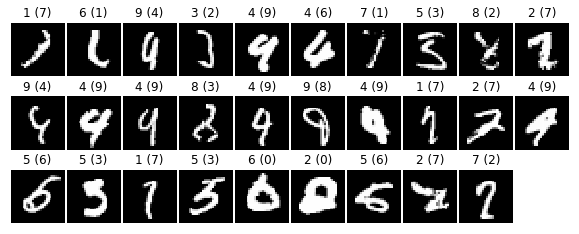

In [89]:
plot(mnist.test.images[wrongs], mnist.test.labels[wrongs], predicted[wrongs]);

In [90]:
pred_vote[wrongs]

array([[ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  4.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  3.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  4.],
       [ 0.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  3.